**Setup**

# Pseudocode approach
1. Load video and extract frames
2. Apply background subtraction to detect moving objects (falling nails)
3. For each detected moving object:
   - Analyze color/hue to identify rust (brown/orange tones)
   - Check shape characteristics (elongated, thin objects)
   - Classify as rusted or non-rusted
4. Track objects across frames to avoid double-counting
5. Count only non-rusted nails that complete falling motion

**Step 1: Install Required Packages**

In [14]:
!pip install opencv-python numpy matplotlib

**Step 2: Upload Your Video File**

In [15]:
from google.colab import files
import os

# Upload the video file
uploaded = files.upload()

# Get the uploaded filename
video_filename = list(uploaded.keys())[0]
print(f"Uploaded file: {video_filename}")



Saving video-part-1-code-test.mp4 to video-part-1-code-test.mp4
Uploaded file: video-part-1-code-test.mp4


**Step 3: Complete Nail Counting Implementation**

In [20]:
import cv2
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from collections import deque

In [25]:
class NailCounter:
    def __init__(self):
        # Initialize background subtractor
        self.backSub = cv2.createBackgroundSubtractorMOG2(history=200, varThreshold=20, detectShadows=False)

        # Tracking variables
        self.trackers = {}
        self.next_object_id = 0
        self.counted_nails = set()

        # Rust color ranges in HSV
        self.rust_lower1 = np.array([0, 30, 30])
        self.rust_upper1 = np.array([15, 255, 200])
        self.rust_lower2 = np.array([160, 30, 30])
        self.rust_upper2 = np.array([180, 255, 200])

        # Counters
        self.total_nails_counted = 0
        self.non_rusted_count = 0

        # Parameters
        self.min_contour_area = 25
        self.max_contour_area = 3000

        # Tracking parameters
        self.max_disappeared = 15  # Frames to keep tracker without detection
        self.max_distance = 80     # Max pixel distance for tracking association

        # Falling motion parameters
        self.min_falling_distance = 50  # Minimum pixels nail should fall to be counted
        self.bottom_threshold = 50      # Distance from bottom to consider nail completed falling

        # Debug info
        self.frame_count = 0

    def is_rusted(self, frame, contour):
        """Check if the detected object is rusted based on color analysis"""
        try:
            # Create mask for the contour region
            mask = np.zeros(frame.shape[:2], dtype=np.uint8)
            cv2.drawContours(mask, [contour], -1, 255, -1)

            # Convert to HSV for better color analysis
            hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

            # Get the region of interest
            roi = cv2.bitwise_and(hsv, hsv, mask=mask)

            # Check for rust colors
            rust_mask1 = cv2.inRange(roi, self.rust_lower1, self.rust_upper1)
            rust_mask2 = cv2.inRange(roi, self.rust_lower2, self.rust_upper2)
            rust_mask = cv2.bitwise_or(rust_mask1, rust_mask2)

            # Count rust pixels
            rust_pixels = cv2.countNonZero(rust_mask)
            total_pixels = cv2.countNonZero(mask)

            if total_pixels == 0:
                return False

            rust_ratio = rust_pixels / total_pixels

            # If more than 20% of the area shows rust color, consider it rusted
            return rust_ratio > 0.20

        except Exception as e:
            return False

    def is_nail_shaped(self, contour):
        """Check if contour has nail-like shape characteristics"""
        try:
            # Get bounding rectangle
            x, y, w, h = cv2.boundingRect(contour)

            # Avoid division by zero
            if w == 0:
                return False

            # Calculate aspect ratio
            aspect_ratio = h / w

            # Nails usually have reasonable aspect ratio
            if aspect_ratio < 1.1 or aspect_ratio > 10:
                return False

            # Check area
            area = cv2.contourArea(contour)
            if area < self.min_contour_area or area > self.max_contour_area:
                return False

            # Additional shape checks
            perimeter = cv2.arcLength(contour, True)
            if perimeter == 0:
                return False

            circularity = 4 * np.pi * area / (perimeter * perimeter)
            if circularity > 0.8:  # Too circular
                return False

            return True

        except Exception:
            return False

    def update_tracking(self, detections, frame_height, frame_width):
        """Enhanced object tracking across frames"""
        current_tracks = {}

        # If no detections, just update disappearances
        if len(detections) == 0:
            for obj_id in list(self.trackers.keys()):
                self.trackers[obj_id]['frames_since_update'] += 1
                if self.trackers[obj_id]['frames_since_update'] > self.max_disappeared:
                    # Check if we should count this object before removing
                    self._check_and_count(obj_id, frame_height)
                    del self.trackers[obj_id]
            return

        # If no existing trackers, create new ones for all detections
        if len(self.trackers) == 0:
            for contour, centroid, is_rusted in detections:
                self._create_new_tracker(contour, centroid, is_rusted)
            return

        # Match existing trackers with current detections
        unmatched_trackers = list(self.trackers.keys())
        unmatched_detections = list(range(len(detections)))
        matches = []

        # Find best matches based on distance and direction
        for i, (contour, centroid, is_rusted) in enumerate(detections):
            best_tracker = None
            min_distance = float('inf')

            for obj_id in unmatched_trackers:
                tracker = self.trackers[obj_id]
                last_centroid = tracker['centroid']

                # Calculate distance
                distance = np.linalg.norm(np.array(centroid) - np.array(last_centroid))

                # Check if this is a good match (close and reasonable movement)
                if distance < self.max_distance and distance < min_distance:
                    # Prefer matches that show downward movement (falling)
                    if centroid[1] > last_centroid[1] or distance < 30:
                        min_distance = distance
                        best_tracker = obj_id

            if best_tracker is not None:
                matches.append((best_tracker, i))
                unmatched_trackers.remove(best_tracker)
                unmatched_detections.remove(i)

        # Update matched trackers
        for obj_id, det_idx in matches:
            contour, centroid, is_rusted = detections[det_idx]
            self.trackers[obj_id]['centroid'] = centroid
            self.trackers[obj_id]['contour'] = contour
            self.trackers[obj_id]['is_rusted'] = is_rusted
            self.trackers[obj_id]['frames_since_update'] = 0
            self.trackers[obj_id]['frames_tracked'] += 1

            # Update trail for visualization
            if 'trail' not in self.trackers[obj_id]:
                self.trackers[obj_id]['trail'] = deque(maxlen=20)
            self.trackers[obj_id]['trail'].append(centroid)

            # Update start position if this is early in tracking
            if self.trackers[obj_id]['frames_tracked'] < 5:
                self.trackers[obj_id]['start_position'] = centroid

            current_tracks[obj_id] = self.trackers[obj_id]

            # Check if this object should be counted
            self._check_and_count(obj_id, frame_height)

        # Create new trackers for unmatched detections
        for det_idx in unmatched_detections:
            contour, centroid, is_rusted = detections[det_idx]
            self._create_new_tracker(contour, centroid, is_rusted)

        # Remove trackers that haven't been updated for too long
        for obj_id in unmatched_trackers:
            self.trackers[obj_id]['frames_since_update'] += 1
            if self.trackers[obj_id]['frames_since_update'] > self.max_disappeared:
                # Check if we should count this object before removing
                self._check_and_count(obj_id, frame_height)
                del self.trackers[obj_id]

    def _create_new_tracker(self, contour, centroid, is_rusted):
        """Helper method to create a new tracker"""
        obj_id = self.next_object_id
        self.trackers[obj_id] = {
            'centroid': centroid,
            'contour': contour,
            'is_rusted': is_rusted,
            'frames_since_update': 0,
            'frames_tracked': 1,
            'start_position': centroid,
            'counted': False,
            'trail': deque([centroid], maxlen=20)
        }
        self.next_object_id += 1
        print(f"→ New tracker {obj_id} at position {centroid}")

    def _check_and_count(self, obj_id, frame_height):
        """Check if a tracked object should be counted as a completed falling nail"""
        tracker = self.trackers[obj_id]

        # Don't count if already counted or not tracked long enough
        if tracker['counted'] or tracker['frames_tracked'] < 3:
            return

        current_y = tracker['centroid'][1]
        start_y = tracker['start_position'][1]

        # Calculate falling distance
        falling_distance = current_y - start_y

        # Check if nail has completed falling motion (near bottom and sufficient falling distance)
        is_near_bottom = current_y > frame_height - self.bottom_threshold
        has_fallen_enough = falling_distance > self.min_falling_distance

        # Additional check: if moving very slowly or stopped near bottom
        if 'trail' in tracker and len(tracker['trail']) > 5:
            recent_points = list(tracker['trail'])[-5:]
            if len(recent_points) >= 2:
                recent_movement = np.linalg.norm(np.array(recent_points[-1]) - np.array(recent_points[0]))
                is_moving_slowly = recent_movement < 10

                if is_near_bottom and (has_fallen_enough or is_moving_slowly):
                    self._count_nail(obj_id)

    def _count_nail(self, obj_id):
        """Count a nail and mark it as counted"""
        if obj_id in self.counted_nails:
            return

        tracker = self.trackers[obj_id]
        is_rusted = tracker['is_rusted']

        self.total_nails_counted += 1
        if not is_rusted:
            self.non_rusted_count += 1

        self.counted_nails.add(obj_id)
        tracker['counted'] = True

        falling_distance = tracker['centroid'][1] - tracker['start_position'][1]
        print(f"✓ Counted nail {obj_id} - {'RUSTED' if is_rusted else 'NON-RUSTED'} - "
              f"Fell {falling_distance:.1f} pixels over {tracker['frames_tracked']} frames")

    def process_frame(self, frame):
        """Process a single frame to detect and count nails"""
        self.frame_count += 1

        # Apply background subtraction
        fg_mask = self.backSub.apply(frame)

        # Noise removal
        kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel_open)
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_CLOSE, kernel_close)

        # Apply threshold
        _, fg_mask = cv2.threshold(fg_mask, 128, 255, cv2.THRESH_BINARY)

        # Find contours
        contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        detections = []

        for contour in contours:
            area = cv2.contourArea(contour)

            # Filter by area
            if area < self.min_contour_area or area > self.max_contour_area:
                continue

            # Check if nail-shaped
            if not self.is_nail_shaped(contour):
                continue

            # Calculate centroid
            M = cv2.moments(contour)
            if M["m00"] == 0:
                continue

            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])

            # Check for rust
            is_rusted = self.is_rusted(frame, contour)

            detections.append((contour, (cx, cy), is_rusted))

        # Update tracking
        self.update_tracking(detections, frame.shape[0], frame.shape[1])

        # Debug info
        if self.frame_count % 15 == 0:
            active_trackers = len([t for t in self.trackers.values() if not t['counted']])
            print(f"Frame {self.frame_count}: {len(detections)} detections, {active_trackers} active trackers")

        return detections, fg_mask

    def draw_results(self, frame, detections):
        """Draw detection and counting results on frame"""
        result_frame = frame.copy()

        # Draw falling motion requirements (visual guide)
        cv2.line(result_frame, (0, frame.shape[0] - self.bottom_threshold),
                (frame.shape[1], frame.shape[0] - self.bottom_threshold),
                (255, 255, 0), 2)  # Blue line for bottom threshold

        # Draw all detections
        for contour, centroid, is_rusted in detections:
            color = (0, 255, 0) if not is_rusted else (0, 0, 255)
            cv2.drawContours(result_frame, [contour], -1, color, 2)
            cv2.circle(result_frame, centroid, 4, color, -1)

        # Draw tracking info with trails
        for obj_id, tracker in self.trackers.items():
            centroid = tracker['centroid']
            is_rusted = tracker['is_rusted']
            color = (0, 255, 0) if not is_rusted else (0, 0, 255)

            # Draw ID
            status = "✓" if tracker['counted'] else "→"
            cv2.putText(result_frame, f"{status}{obj_id}", (centroid[0] + 10, centroid[1]),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

            # Draw trail if available
            if 'trail' in tracker and len(tracker['trail']) > 1:
                trail_points = list(tracker['trail'])
                for i in range(1, len(trail_points)):
                    cv2.line(result_frame, trail_points[i-1], trail_points[i], color, 1)

            # Draw start position and falling distance
            if 'start_position' in tracker and not tracker['counted']:
                start_pos = tracker['start_position']
                cv2.circle(result_frame, start_pos, 3, (255, 255, 0), -1)  # Cyan for start
                cv2.line(result_frame, start_pos, centroid, (255, 255, 0), 1)

                # Show falling distance
                falling_dist = centroid[1] - start_pos[1]
                cv2.putText(result_frame, f"{falling_dist}px",
                           (centroid[0], centroid[1] - 20),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1)

        # Draw counters with enhanced information
        y_offset = 35
        texts = [
            f"Frame: {self.frame_count}",
            f"Total Nails: {self.total_nails_counted}",
            f"Non-rusted: {self.non_rusted_count}",
            f"Active Trackers: {len([t for t in self.trackers.values() if not t['counted']])}",
            f"Counting: Bottom-{self.bottom_threshold}px, MinFall-{self.min_falling_distance}px"
        ]

        for i, text in enumerate(texts):
            text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)[0]
            cv2.rectangle(result_frame, (5, y_offset*i + 5),
                         (5 + text_size[0] + 10, y_offset*i + 35), (0, 0, 0), -1)

            color = (0, 255, 0) if "Non-rusted" in text else (255, 255, 255)
            cv2.putText(result_frame, text, (10, y_offset*(i+1)),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        return result_frame

**Debug Function**

=== DEBUG MODE ===
Testing first frame detection...


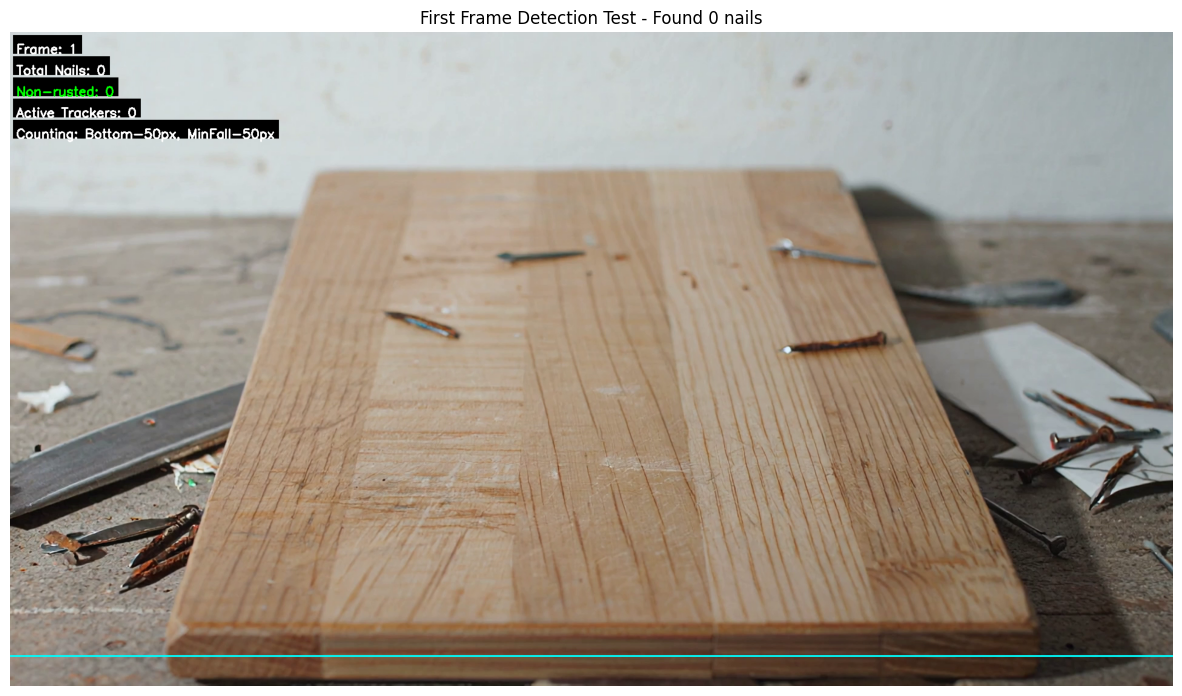

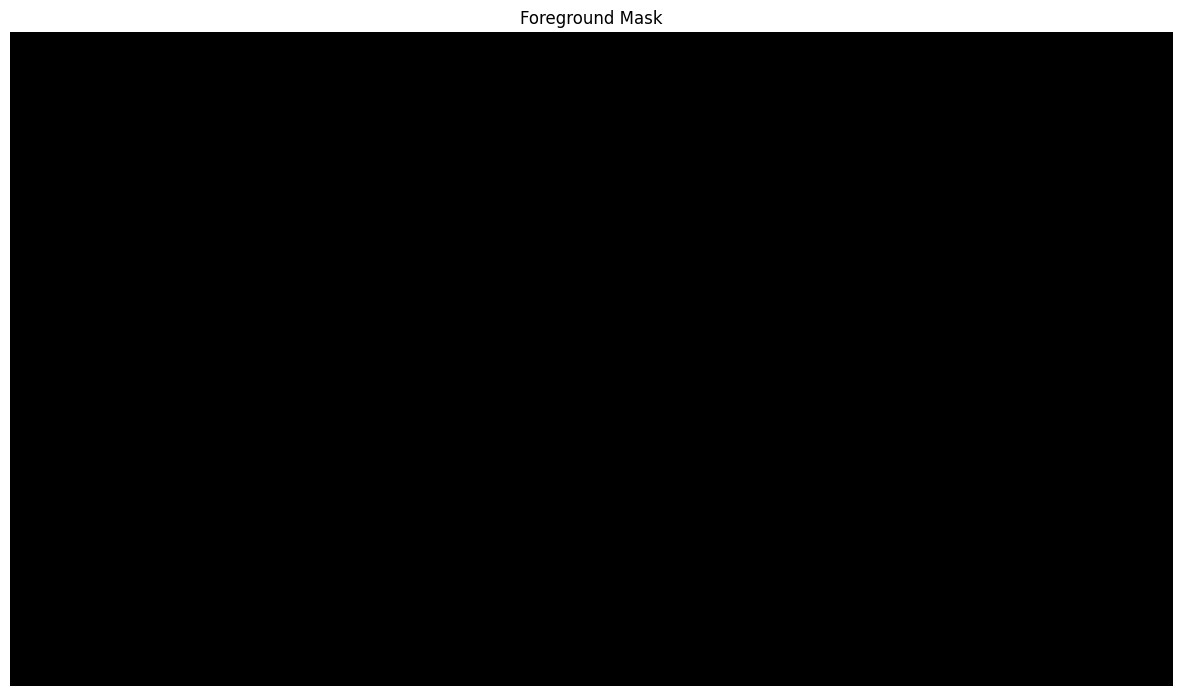

Detected 0 potential nails in first frame
No nails detected in first frame - checking background subtraction...


In [26]:
def debug_first_frame(video_path):
    """Debug function to test detection on first frame"""
    debug_counter = NailCounter()

    cap = cv2.VideoCapture(video_path)
    ret, test_frame = cap.read()
    if ret:
        print("Testing first frame detection...")
        test_detections, test_mask = debug_counter.process_frame(test_frame)
        test_result = debug_counter.draw_results(test_frame, test_detections)

        # Convert to RGB for display
        test_result_rgb = cv2.cvtColor(test_result, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(15, 10))
        plt.imshow(test_result_rgb)
        plt.title(f"First Frame Detection Test - Found {len(test_detections)} nails")
        plt.axis('off')
        plt.show()

        # Also show the foreground mask
        plt.figure(figsize=(15, 10))
        plt.imshow(test_mask, cmap='gray')
        plt.title("Foreground Mask")
        plt.axis('off')
        plt.show()

        print(f"Detected {len(test_detections)} potential nails in first frame")
        if len(test_detections) > 0:
            for i, (contour, centroid, is_rusted) in enumerate(test_detections):
                print(f"  Nail {i+1}: Position {centroid}, Rusted: {is_rusted}")
        else:
            print("No nails detected in first frame - checking background subtraction...")

    cap.release()
    return debug_counter

# Run the debug function
print("=== DEBUG MODE ===")
debug_nail_counter = debug_first_frame(video_filename)

In [28]:
def process_video_colab(video_path):
    """Main function to process video in Colab"""

    # Initialize nail counter
    nail_counter = NailCounter()

    # Open video
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video file")
        return

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Video Info: {width}x{height}, {fps:.2f} FPS, {total_frames} frames")
    print(f"Counting parameters: Bottom threshold={nail_counter.bottom_threshold}px, "
          f"Min falling distance={nail_counter.min_falling_distance}px")

    # Setup video writer for output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_path = 'nail_counting_output.mp4'
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    print("Processing video...")
    frame_count = 0

    # Process each frame
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Process frame
        detections, fg_mask = nail_counter.process_frame(frame)

        # Draw results
        result_frame = nail_counter.draw_results(frame, detections)

        # Write frame to output video
        out.write(result_frame)

        # Display progress
        frame_count += 1
        if frame_count % 10 == 0:
            active = len([t for t in nail_counter.trackers.values() if not t['counted']])
            print(f"Frame {frame_count}/{total_frames}: {len(detections)} detections, "
                  f"{active} active, {nail_counter.non_rusted_count} non-rusted")

    # Release everything
    cap.release()
    out.release()

    # Print final results
    print("\n" + "="*60)
    print("🎯 FINAL RESULTS:")
    print(f"Total nails counted: {nail_counter.total_nails_counted}")
    print(f"Non-rusted nails: {nail_counter.non_rusted_count}")
    print(f"Maximum objects tracked: {nail_counter.next_object_id}")
    print(f"Output video saved as: {output_path}")
    print("="*60)

    return output_path, nail_counter.non_rusted_count

In [29]:
# Run the main processing
print("\n=== MAIN PROCESSING ===")
output_video_path, final_count = process_video_colab(video_filename)


=== MAIN PROCESSING ===
Video Info: 1920x1080, 24.00 FPS, 241 frames
Counting parameters: Bottom threshold=50px, Min falling distance=50px
Processing video...
→ New tracker 0 at position (906, 70)
Frame 10/241: 0 detections, 1 active, 0 non-rusted
Frame 15: 1 detections, 1 active trackers
→ New tracker 1 at position (910, 233)
→ New tracker 2 at position (1204, 202)
→ New tracker 3 at position (893, 169)
→ New tracker 4 at position (1162, 467)
→ New tracker 5 at position (899, 439)
→ New tracker 6 at position (910, 377)
→ New tracker 7 at position (1355, 564)
→ New tracker 8 at position (1377, 555)
→ New tracker 9 at position (1099, 632)
Frame 20/241: 2 detections, 10 active, 0 non-rusted
→ New tracker 10 at position (933, 677)
→ New tracker 11 at position (924, 643)
Frame 30: 1 detections, 12 active trackers
Frame 30/241: 1 detections, 12 active, 0 non-rusted
→ New tracker 12 at position (772, 883)
→ New tracker 13 at position (803, 839)
→ New tracker 14 at position (755, 918)
→ New 

**Display Sample Results**

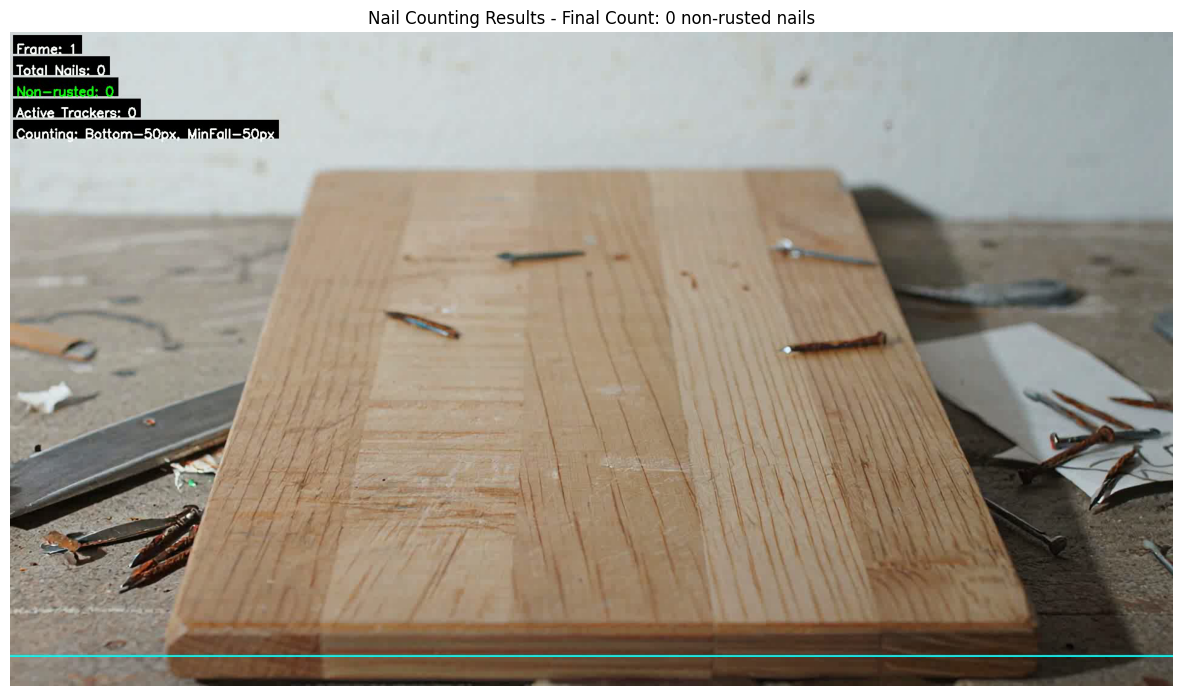

✅ Processing complete! Final count: 0 non-rusted nails


In [30]:
# Display a sample frame from the output
cap = cv2.VideoCapture(output_video_path)
ret, sample_frame = cap.read()
if ret:
    # Convert BGR to RGB for matplotlib
    sample_frame_rgb = cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 10))
    plt.imshow(sample_frame_rgb)
    plt.title(f"Nail Counting Results - Final Count: {final_count} non-rusted nails")
    plt.axis('off')
    plt.show()

cap.release()

print(f"✅ Processing complete! Final count: {final_count} non-rusted nails")

**Download Output Video**

In [31]:
# Download the output video
from google.colab import files

if os.path.exists('nail_counting_output.mp4'):
    files.download('nail_counting_output.mp4')
    print("✅ Output video downloaded! You can submit this file.")
else:
    print("❌ Output video not found. Please check the processing steps.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Output video downloaded! You can submit this file.


**Additional Analysis**

In [32]:
# Show detailed analysis
print("\n📊 DETAILED ANALYSIS:")
cap = cv2.VideoCapture(video_filename)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
duration = total_frames / fps
cap.release()

print(f"• Video duration: {duration:.2f} seconds")
print(f"• Total frames processed: {total_frames}")
print(f"• Frame rate: {fps:.2f} FPS")
print(f"• Final non-rusted nail count: {final_count}")
print(f"• Output file: {output_video_path}")


📊 DETAILED ANALYSIS:
• Video duration: 10.04 seconds
• Total frames processed: 241
• Frame rate: 24.00 FPS
• Final non-rusted nail count: 0
• Output file: nail_counting_output.mp4
